# Problem 4.2 - Hierarchial Clustering

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
df = pd.read_csv("./Data/4.2/CSV/TLBR_68.csv")
df = df.drop(columns=['Unnamed: 0'])
display(df)

,Top-Left,Bottom-Right,Id
0,"[290, 85]","[435, 147]",0
1,"[563, 82]","[730, 147]",1
2,"[744, 92]","[940, 140]",2
3,"[1163, 92]","[1184, 147]",3
4,"[1218, 79]","[1344, 157]",4
...,...,...,...
493,"[1566, 3264]","[1740, 3315]",493
494,"[1762, 3261]","[1851, 3315]",494
495,"[1958, 3261]","[2100, 3312]",495
496,"[2120, 3250]","[2163, 3315]",496


### Building the `euclidean` dataframe

In [3]:
df_columns = df.columns.tolist()
reordered_df_columns = df_columns[-1:] + df_columns[:-1]

new_columns = ['Top', 'Left', 'Bottom', 'Right', 'Top_Box', 'Left_Box', 'Bottom_Box', 'Right_Box']
euclidean = pd.DataFrame(columns = df_columns[-1:] + df_columns[:-1] + new_columns)
euclidean = pd.concat([euclidean, df], axis=0)

for i, data in euclidean.iterrows():
    left, top = data['Top-Left'].split(", ")
    right, bottom = data['Bottom-Right'].split(", ")
    
    left    =  int(left[1:])
    right   =  int(right[1:])
    top     =  int(top[:-1])
    bottom  =  int(bottom[:-1])

    top_left      = np.array([left, top])
    bottom_right  = np.array([right, bottom])
    top_coords    = np.array([(left + right) // 2, top])
    left_coords   = np.array([left, (top + bottom) // 2])
    bottom_coords = np.array([(left + right) // 2, bottom])
    right_coords  = np.array([right, (top + bottom) // 2])

    top_box = bottom_box = left_box = right_box = np.array([-1, 0])

    new_data = [data['Id'], top_left, bottom_right, top_coords, left_coords, bottom_coords, right_coords, top_box, left_box, bottom_box, right_box]
    euclidean.loc[i] = new_data

display(euclidean)

,Id,Top-Left,Bottom-Right,Top,Left,Bottom,Right,Top_Box,Left_Box,Bottom_Box,Right_Box
0,0,"[290, 85]","[435, 147]","[362, 85]","[290, 116]","[362, 147]","[435, 116]","[-1, 0]","[-1, 0]","[-1, 0]","[-1, 0]"
1,1,"[563, 82]","[730, 147]","[646, 82]","[563, 114]","[646, 147]","[730, 114]","[-1, 0]","[-1, 0]","[-1, 0]","[-1, 0]"
2,2,"[744, 92]","[940, 140]","[842, 92]","[744, 116]","[842, 140]","[940, 116]","[-1, 0]","[-1, 0]","[-1, 0]","[-1, 0]"
3,3,"[1163, 92]","[1184, 147]","[1173, 92]","[1163, 119]","[1173, 147]","[1184, 119]","[-1, 0]","[-1, 0]","[-1, 0]","[-1, 0]"
4,4,"[1218, 79]","[1344, 157]","[1281, 79]","[1218, 118]","[1281, 157]","[1344, 118]","[-1, 0]","[-1, 0]","[-1, 0]","[-1, 0]"
...,...,...,...,...,...,...,...,...,...,...,...
493,493,"[1566, 3264]","[1740, 3315]","[1653, 3264]","[1566, 3289]","[1653, 3315]","[1740, 3289]","[-1, 0]","[-1, 0]","[-1, 0]","[-1, 0]"
494,494,"[1762, 3261]","[1851, 3315]","[1806, 3261]","[1762, 3288]","[1806, 3315]","[1851, 3288]","[-1, 0]","[-1, 0]","[-1, 0]","[-1, 0]"
495,495,"[1958, 3261]","[2100, 3312]","[2029, 3261]","[1958, 3286]","[2029, 3312]","[2100, 3286]","[-1, 0]","[-1, 0]","[-1, 0]","[-1, 0]"
496,496,"[2120, 3250]","[2163, 3315]","[2141, 3250]","[2120, 3282]","[2141, 3315]","[2163, 3282]","[-1, 0]","[-1, 0]","[-1, 0]","[-1, 0]"


In [4]:
directions = ['Top', 'Left', 'Bottom', 'Right']

for i in range(len(euclidean)):
    boxes = np.full((4, 2), np.array([np.inf, -1]))

    data = euclidean.copy().to_numpy()
    data[i:-1, :] = data[i+1:, :]
    data = data[:-1, :]

    for j, direction in enumerate(directions):
        distances = np.array([np.linalg.norm(coord - euclidean.loc[i][direction]) for coord in data[:, ((j + 2) % 4) + 3]])

        if len(distances):
            distance = np.min(distances)
            index = np.argmin(distances)

            boxes[j] = min(np.array([distance, data[index, 0]]), boxes[j], key=lambda x: x[0])

    boxes = np.where(boxes == -1, 0, boxes)
    boxes = np.where(boxes == np.inf, -1, boxes)

    boxes[:, 0] = np.round(boxes[:, 0], 2)

    for j, direction in enumerate(directions):
        euclidean.loc[i][direction + '_Box'] = boxes[j]

display(euclidean)

,Id,Top-Left,Bottom-Right,Top,Left,Bottom,Right,Top_Box,Left_Box,Bottom_Box,Right_Box
0,0,"[290, 85]","[435, 147]","[362, 85]","[290, 116]","[362, 147]","[435, 116]","[212.72, 10.0]","[211.12, 12.0]","[104.62, 10.0]","[128.02, 1.0]"
1,1,"[563, 82]","[730, 147]","[646, 82]","[563, 114]","[646, 147]","[730, 114]","[204.4, 2.0]","[128.02, 0.0]","[83.87, 11.0]","[14.14, 2.0]"
2,2,"[744, 92]","[940, 140]","[842, 92]","[744, 116]","[842, 140]","[940, 116]","[203.57, 1.0]","[14.14, 1.0]","[167.29, 16.0]","[223.02, 3.0]"
3,3,"[1163, 92]","[1184, 147]","[1173, 92]","[1163, 119]","[1173, 147]","[1184, 119]","[126.05, 4.0]","[181.0, 4.0]","[127.62, 4.0]","[34.01, 4.0]"
4,4,"[1218, 79]","[1344, 157]","[1281, 79]","[1218, 118]","[1281, 157]","[1344, 118]","[127.62, 3.0]","[34.01, 3.0]","[126.05, 3.0]","[41.0, 5.0]"
...,...,...,...,...,...,...,...,...,...,...,...
493,493,"[1566, 3264]","[1740, 3315]","[1653, 3264]","[1566, 3289]","[1653, 3315]","[1740, 3289]","[96.88, 481.0]","[20.25, 492.0]","[162.25, 494.0]","[22.02, 494.0]"
494,494,"[1762, 3261]","[1851, 3315]","[1806, 3261]","[1762, 3288]","[1806, 3315]","[1851, 3288]","[55.79, 488.0]","[22.02, 493.0]","[150.05, 488.0]","[107.02, 495.0]"
495,495,"[1958, 3261]","[2100, 3312]","[2029, 3261]","[1958, 3286]","[2029, 3312]","[2100, 3286]","[66.21, 489.0]","[80.41, 488.0]","[128.02, 496.0]","[20.4, 496.0]"
496,496,"[2120, 3250]","[2163, 3315]","[2141, 3250]","[2120, 3282]","[2141, 3315]","[2163, 3282]","[54.71, 489.0]","[20.4, 495.0]","[107.07, 497.0]","[17.03, 497.0]"


In [5]:
box_centers_initial = np.mean(euclidean[['Top', 'Left', 'Bottom', 'Right']].to_numpy(), axis=1)
box_centers         = np.array([i for i in box_centers_initial])

### Dendrogram obtained by performing clustering on the centers of the bounding boxes using single linkage method

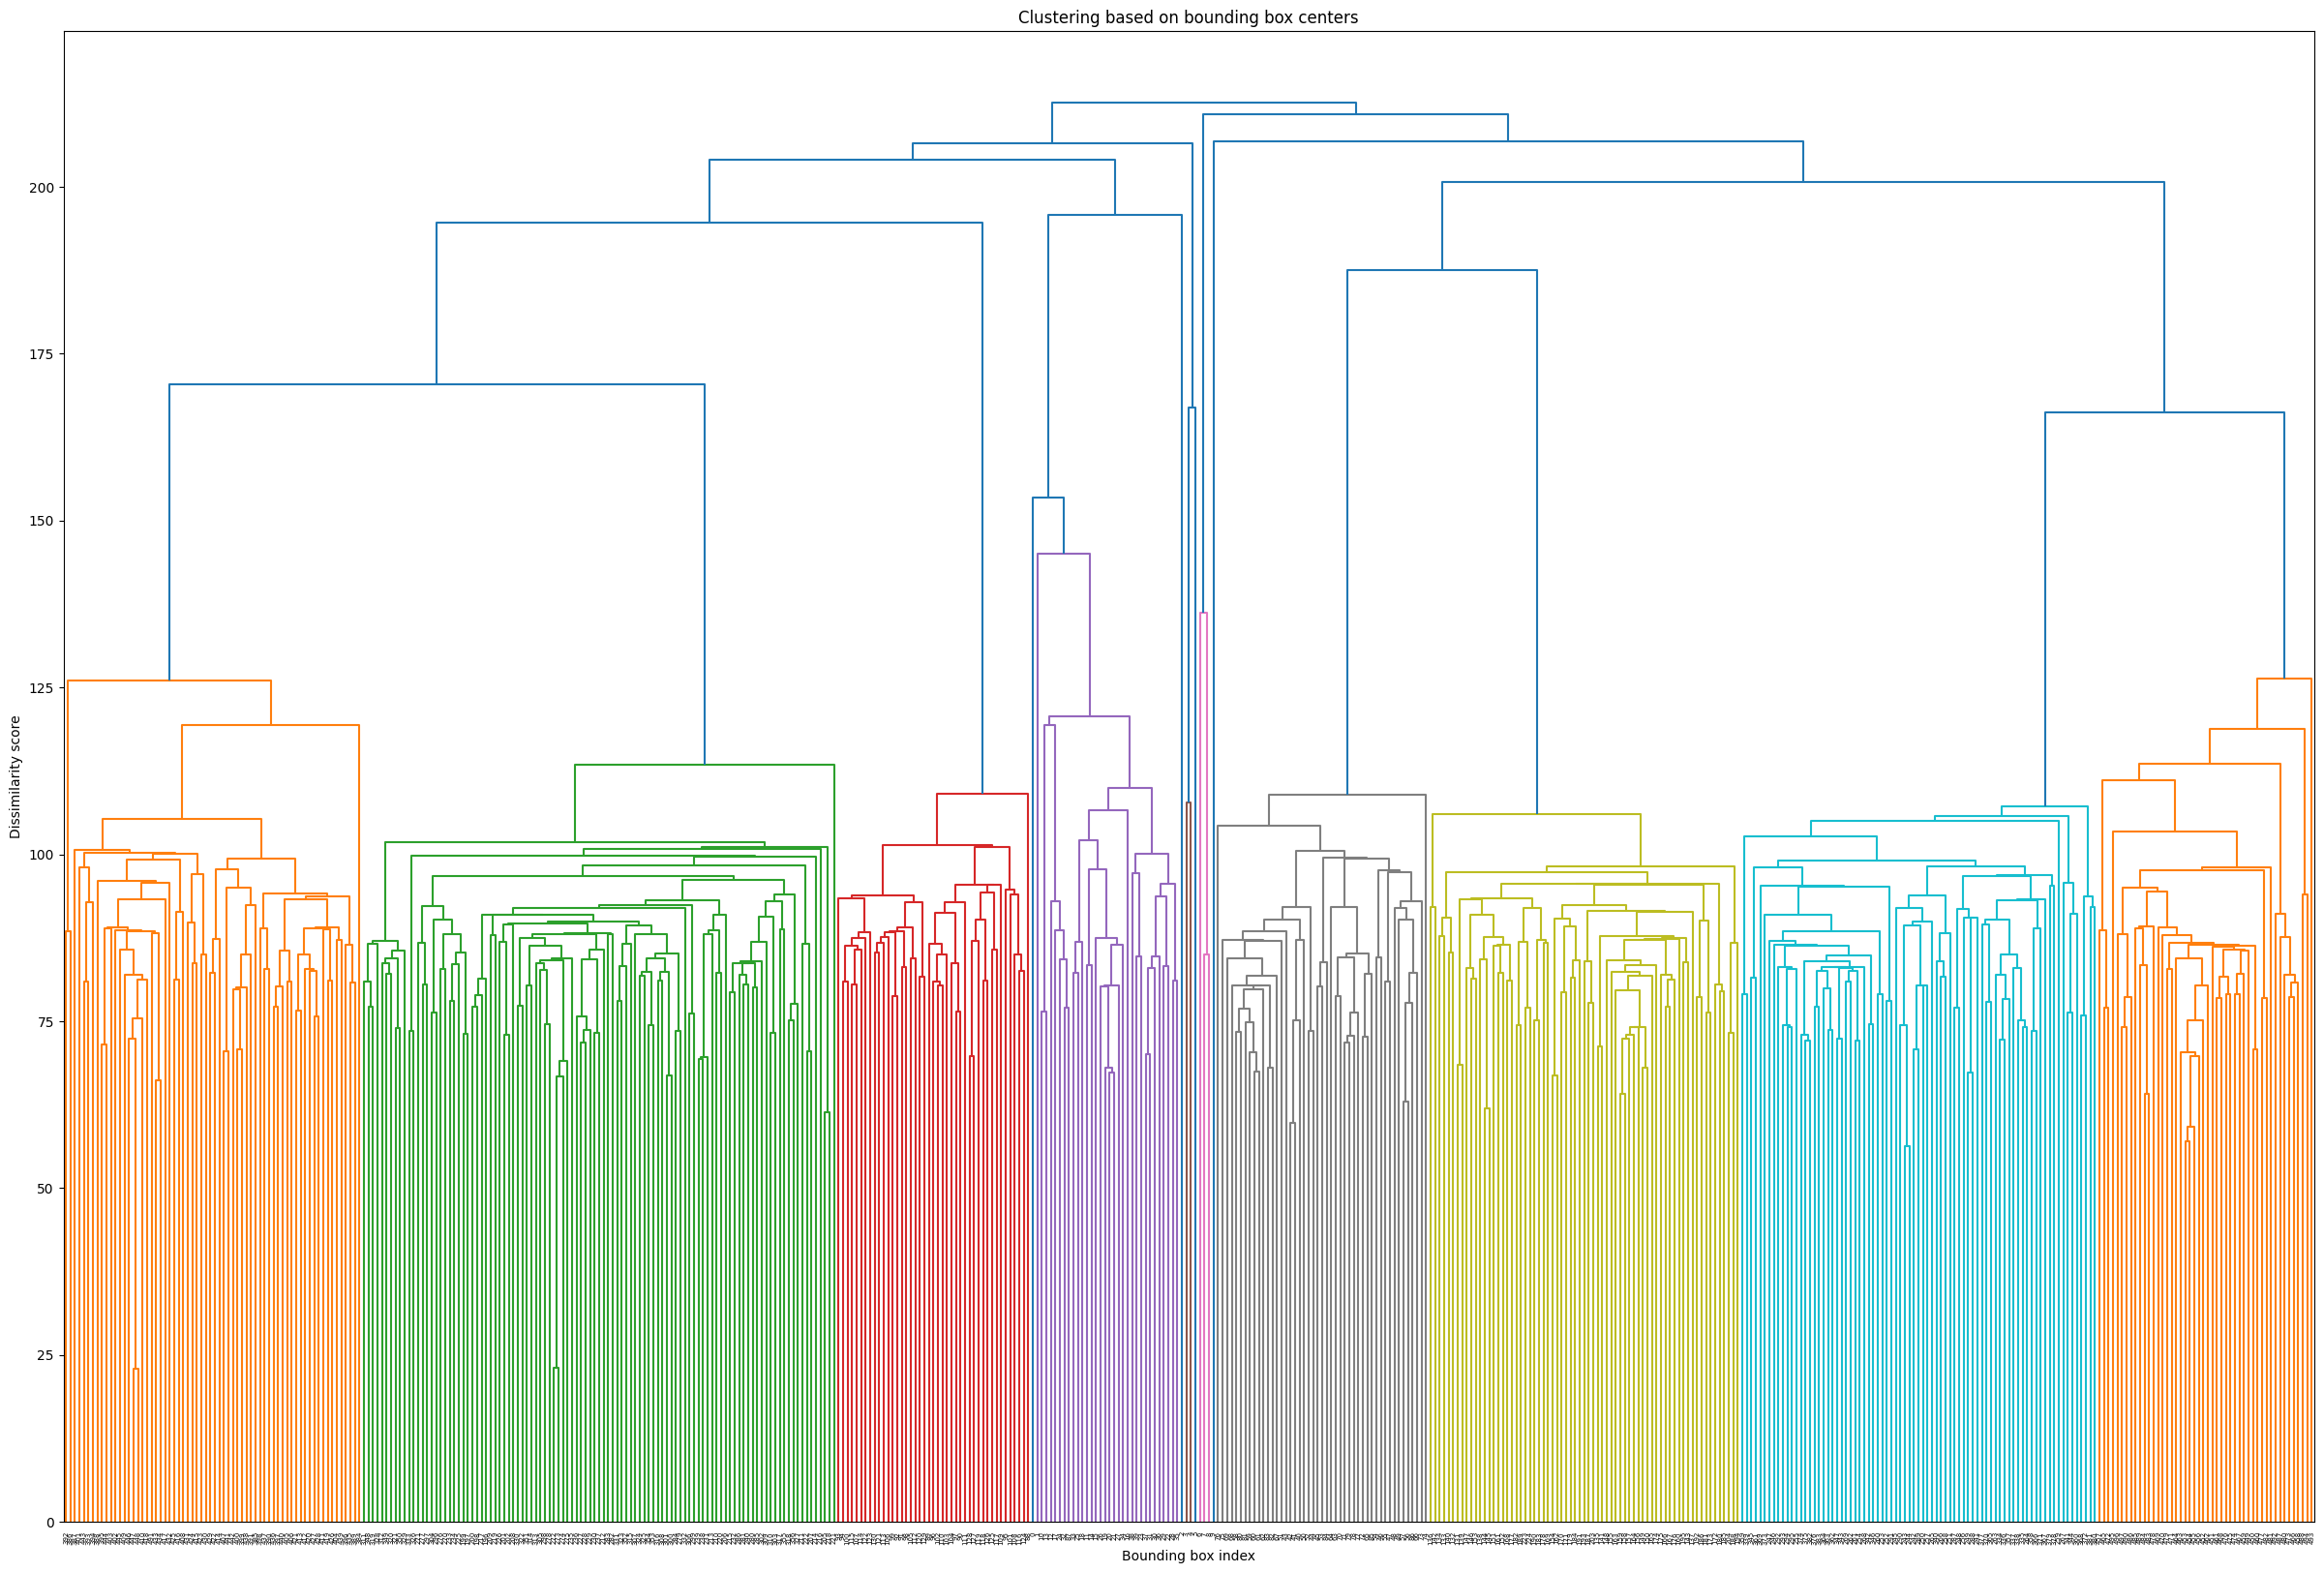

In [6]:
plt.figure(figsize=(30, 20))
linkage_matrix = linkage(box_centers, optimal_ordering=True, method='single')
cluster_data   = dendrogram(linkage_matrix)
plt.xlabel('Bounding box index')
plt.ylabel('Dissimilarity score')
plt.title('Clustering based on bounding box centers')
plt.show()

### Calculation of WCSS - Within Cluster Sum of Squares score and Silhouette score for different number of clusters to find the optimal number of clusters

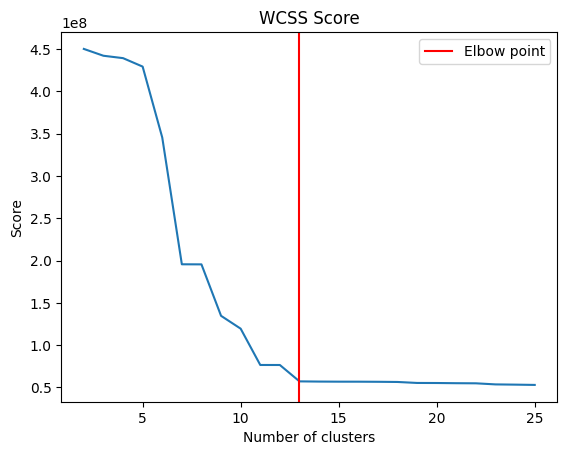

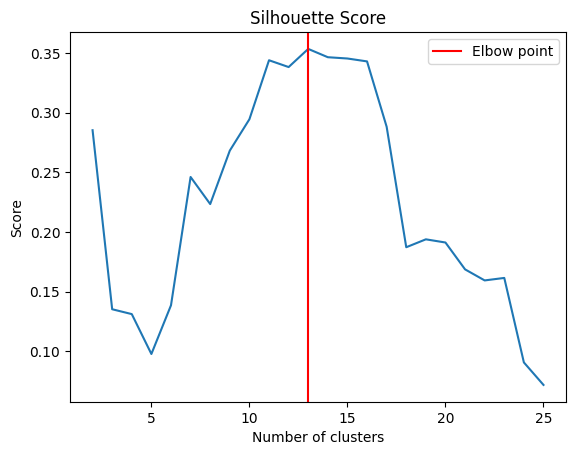

In [7]:
WCSS, silhouette_scores = [], []

for n_regions in range(2, 26):
    cluster_labels = fcluster(linkage_matrix, t=n_regions, criterion='maxclust')

    sscore = silhouette_score(box_centers, cluster_labels)
    silhouette_scores.append(sscore)

    regions = []
    for i in range(n_regions):
        points = box_centers[cluster_labels == i + 1]
        regions.append(points)

    wcss = 0
    for i in regions:
        wcss += np.sum((i - np.mean(i, axis=0)) ** 2)
    WCSS.append(wcss)

plt.plot(range(2, 26), WCSS)
plt.axvline(13, c='Red', label='Elbow point')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('WCSS Score')
plt.legend()
plt.show()

plt.plot(range(2, 26), silhouette_scores)
plt.axvline(13, c='Red', label='Elbow point')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Silhouette Score')
plt.legend()
plt.show()

### We can observe that the optimal number of clusters is 13 when using the `maxclust` criterion and the `single` linkage method

#### Removing the connections between boxes that are not part of the same cluster

In [13]:
best_clusters = 13
cluster_labels = fcluster(linkage_matrix, t=13, criterion='maxclust')

indices = np.arange(len(euclidean))
clusters = []
nearest_box_types = ['Top_Box', 'Left_Box', 'Bottom_Box', 'Right_Box']

for i in range(best_clusters):
    points = indices[cluster_labels == i + 1]

    for j in points:
        for box_type in nearest_box_types:
            nearest_box_id = euclidean.loc[j][box_type][1]

            if nearest_box_id not in points:
                euclidean.loc[j][box_type] = [-1, 0]

display(euclidean)

,Id,Top-Left,Bottom-Right,Top,Left,Bottom,Right,Top_Box,Left_Box,Bottom_Box,Right_Box
0,0,"[290, 85]","[435, 147]","[362, 85]","[290, 116]","[362, 147]","[435, 116]","[-1, 0]","[-1, 0]","[-1, 0]","[-1, 0]"
1,1,"[563, 82]","[730, 147]","[646, 82]","[563, 114]","[646, 147]","[730, 114]","[-1, 0]","[-1, 0]","[-1, 0]","[-1, 0]"
2,2,"[744, 92]","[940, 140]","[842, 92]","[744, 116]","[842, 140]","[940, 116]","[-1, 0]","[-1, 0]","[-1, 0]","[-1, 0]"
3,3,"[1163, 92]","[1184, 147]","[1173, 92]","[1163, 119]","[1173, 147]","[1184, 119]","[126.05, 4.0]","[181.0, 4.0]","[127.62, 4.0]","[34.01, 4.0]"
4,4,"[1218, 79]","[1344, 157]","[1281, 79]","[1218, 118]","[1281, 157]","[1344, 118]","[127.62, 3.0]","[34.01, 3.0]","[126.05, 3.0]","[-1, 0]"
...,...,...,...,...,...,...,...,...,...,...,...
493,493,"[1566, 3264]","[1740, 3315]","[1653, 3264]","[1566, 3289]","[1653, 3315]","[1740, 3289]","[96.88, 481.0]","[20.25, 492.0]","[162.25, 494.0]","[22.02, 494.0]"
494,494,"[1762, 3261]","[1851, 3315]","[1806, 3261]","[1762, 3288]","[1806, 3315]","[1851, 3288]","[55.79, 488.0]","[22.02, 493.0]","[150.05, 488.0]","[107.02, 495.0]"
495,495,"[1958, 3261]","[2100, 3312]","[2029, 3261]","[1958, 3286]","[2029, 3312]","[2100, 3286]","[66.21, 489.0]","[80.41, 488.0]","[128.02, 496.0]","[20.4, 496.0]"
496,496,"[2120, 3250]","[2163, 3315]","[2141, 3250]","[2120, 3282]","[2141, 3315]","[2163, 3282]","[54.71, 489.0]","[20.4, 495.0]","[107.07, 497.0]","[17.03, 497.0]"


In [14]:
def visualize_bboxes(img):
  img_2 = img.copy()
  for index, rows in df.iterrows():
    top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
    bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
    cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)

  plt.imshow(img_2)
  plt.axis('off')

In [15]:
def make_connections(image):

  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image_with_boxes = image_rgb.copy()

  for _, row in euclidean.iterrows():
      left = int(row['Left'][0])
      right = int(row['Right'][0])
      top = int(row['Top'][1])
      bottom = int(row['Bottom'][1])
      box_id = int(row['Id'])

      width = right - left
      height = bottom - top

      top_left = (left, top)
      bottom_right = (right, bottom)

      cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 0), 2)

      label_position = (left, top - 10)
      cv2.putText(image_with_boxes, str(box_id), label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

      top_adjacent_id = int(row['Top_Box'][1])
      bottom_adjacent_id = int(row['Bottom_Box'][1])
      left_adjacent_id = int(row['Left_Box'][1])
      right_adjacent_id = int(row['Right_Box'][1])

      if top_adjacent_id != 0:
          top_adjacent_row = euclidean[euclidean['Id'] == top_adjacent_id].iloc[0]
          top_adjacent_center = int(top_adjacent_row['Bottom'][0]) , int(top_adjacent_row['Bottom'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(top)), top_adjacent_center, (0, 255, 0), 2)

      if bottom_adjacent_id != 0:
          bottom_adjacent_row = euclidean[euclidean['Id'] == bottom_adjacent_id].iloc[0]
          bottom_adjacent_center = int(bottom_adjacent_row['Top'][0]) , int(bottom_adjacent_row['Top'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(bottom)), (int(bottom_adjacent_center[0]), int(bottom_adjacent_center[1])), (0, 255, 0), 2)

      if left_adjacent_id != 0:
          left_adjacent_row = euclidean[euclidean['Id'] == left_adjacent_id].iloc[0]
          left_adjacent_center = int(left_adjacent_row['Right'][0]) , int(left_adjacent_row['Right'][1])
          cv2.line(image_with_boxes, (int(left), int(top) + height // 2), (int(left_adjacent_center[0]), int(left_adjacent_center[1])), (0, 255, 0), 2)

      if right_adjacent_id != 0:
          right_adjacent_row = euclidean[euclidean['Id'] == right_adjacent_id].iloc[0]
          right_adjacent_center = int(right_adjacent_row['Left'][0]) , int(right_adjacent_row['Left'][1])
          cv2.line(image_with_boxes, (int(right), int(top) + height // 2), (int(right_adjacent_center[0]), int(right_adjacent_center[1])), (0, 255, 0), 2)

  return image_with_boxes

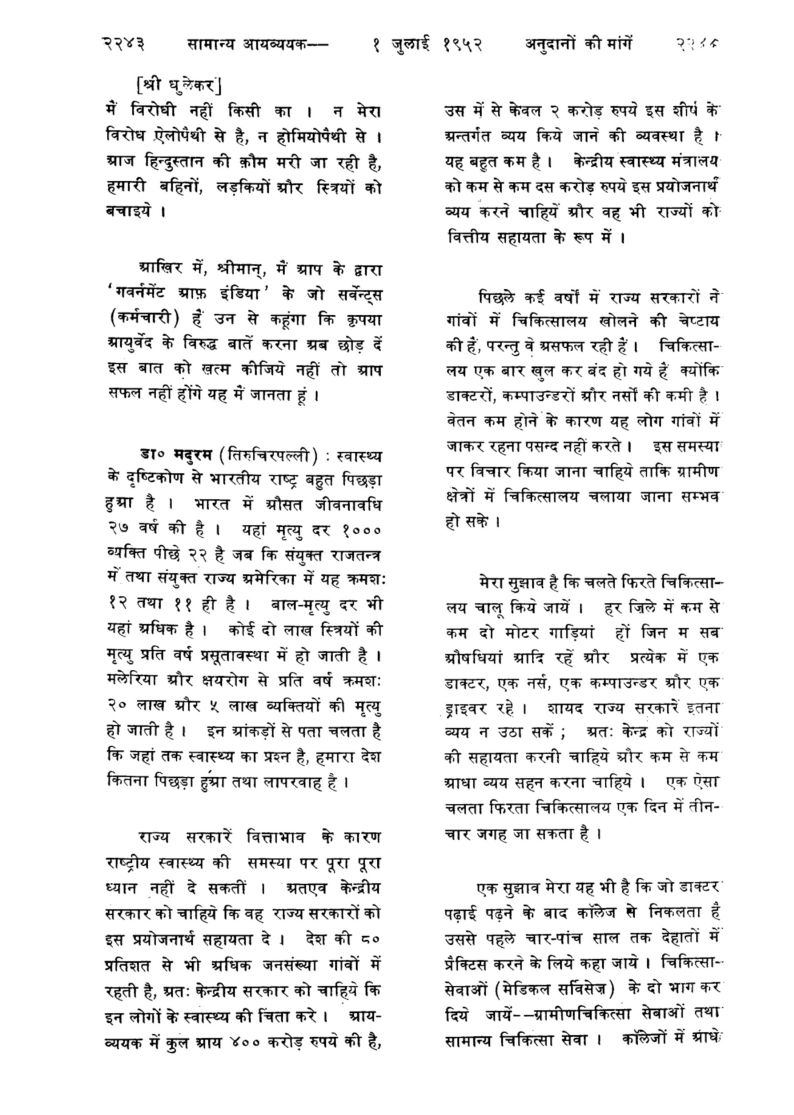

In [16]:
image = cv2.imread('./Data/4.2/images/68.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 20))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

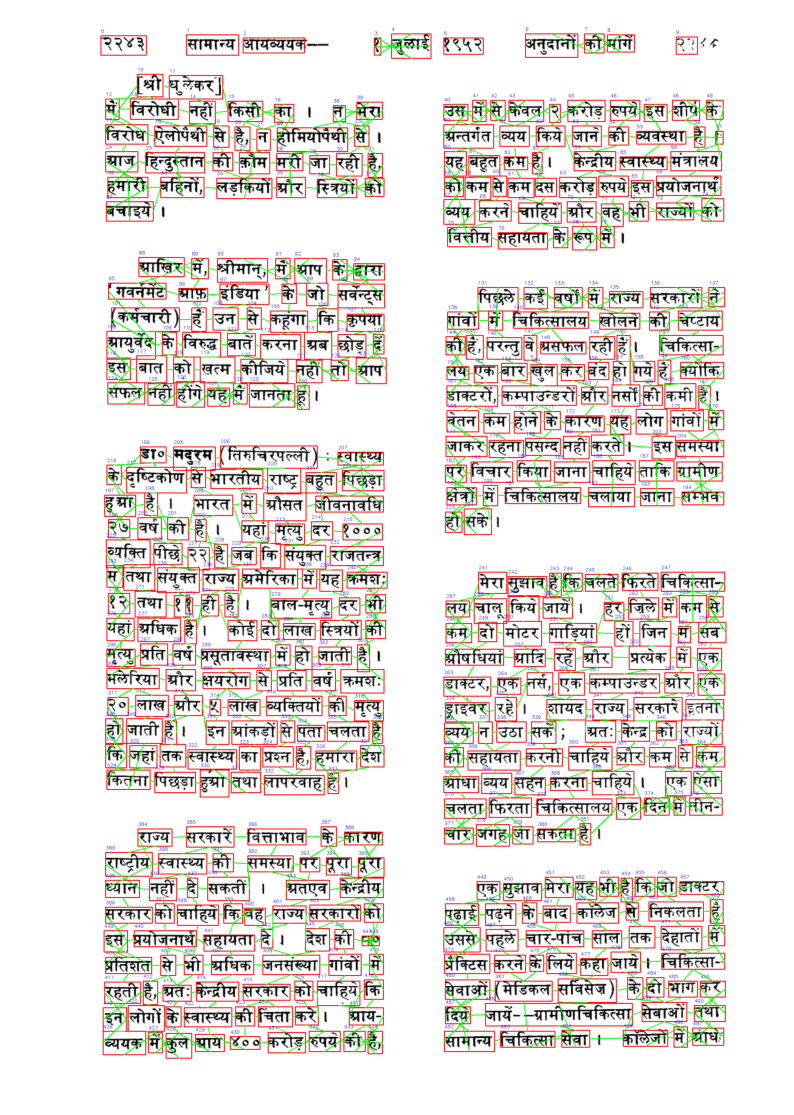

In [17]:
image = make_connections(image)
plt.figure(figsize=(10, 20))
plt.imshow(image)
plt.axis('off')
plt.show()